# Evaluation vorticity GCMx -> 2.2km-4x over Birmingham
With correct grid for GCMx vorticity so it matches 60km vort grid

64x64 pixel target

Includes learnt feature map with 8 channels

## Diff model

Vorticity transform: standardize (based on train set mean and std) then devide by standardized train set max

Target transform: sqrt then divide by sqrted train set max

Sample inverse transform: multiply by train set max, clip negative values to 0 then square

In [1]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree, plot_grid, prep_eval_data, show_samples, distribution_figure, plot_mean_bias, plot_std, plot_psd

In [2]:
split = "val"

datasets = {
    "CPM": "2.2km-coarsened-gcm-2.2km-coarsened-4x_birmingham_vorticity850_random",
    "GCM": "60km-2.2km-coarsened-4x_birmingham_vorticity850_random",
}

runs = [
    # ("gcmx-4x_bham_vorticity850_random-learnt-map-1", 20),
    # ("gcmx-4x_bham_vorticity850_random-learnt-map-2", 20),
    ("gcmx-4x_bham_vorticity850_random-learnt-map-8", 20),
    ("gcmx-4x_bham_vorticity850_random-fixed-gcmx-vort-grid", 11),
]

In [3]:
merged_ds = prep_eval_data(datasets, runs, split)
merged_ds

<xarray.Dataset>
Dimensions:                     (time: 4320, model: 2, source: 2, sample_id: 3,
                                 bnds: 2, grid_latitude: 64, grid_longitude: 64)
Coordinates:
    pressure                    (time) float32 850.0 850.0 850.0 ... 850.0 850.0
  * model                       (model) <U53 'gcmx-4x_bham_vorticity850_rando...
  * time                        (time) object 1980-12-03 12:00:00 ... 2080-11...
    season                      (time) int64 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
  * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
  * sample_id                   (sample_id) int64 0 1 2
  * source                      (source) object 'CPM' 'GCM'
Dimensions without coordinates: bnds
Data variables:
    rotated_latitude_longitude  (source, model, sample_id, time) float64 -2.1...
    time_bnds                   (source, model, sample_id, time, bnds) object ...
    grid_latitude_bnds          (source, model, sample_id, time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (source, model, sample_id, time, grid_longitude, bnds) float32 ...
    pred_pr                     (source, model, sample_id, time, grid_latitude, grid_longitude) float32 ...
    target_pr                   (source, time, grid_latitude, grid_longitude) float32 ...
    vorticity850                (source, time, grid_latitude, grid_longitude) float64 ...

In [4]:
pred_pr = merged_ds["pred_pr"]
target_pr = merged_ds["target_pr"].sel(source="CPM")

total_pred_pr = merged_ds["pred_pr"].mean(dim=["grid_longitude", "grid_latitude"])
total_target_pr = merged_ds["target_pr"].sel(source="CPM").mean(dim=["grid_longitude", "grid_latitude"])

## Samples

In [5]:
sorted_time = total_target_pr.sortby(total_target_pr)["time"].values

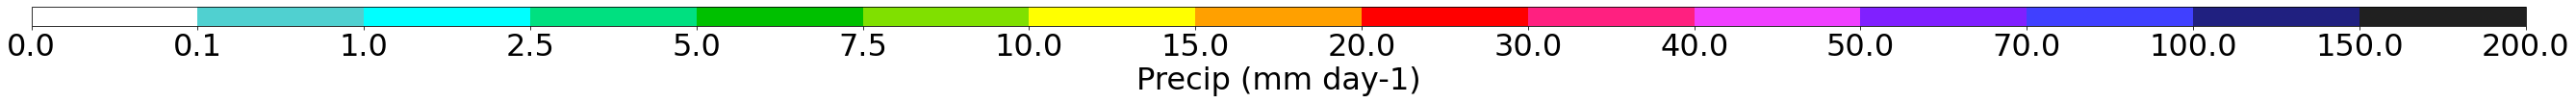

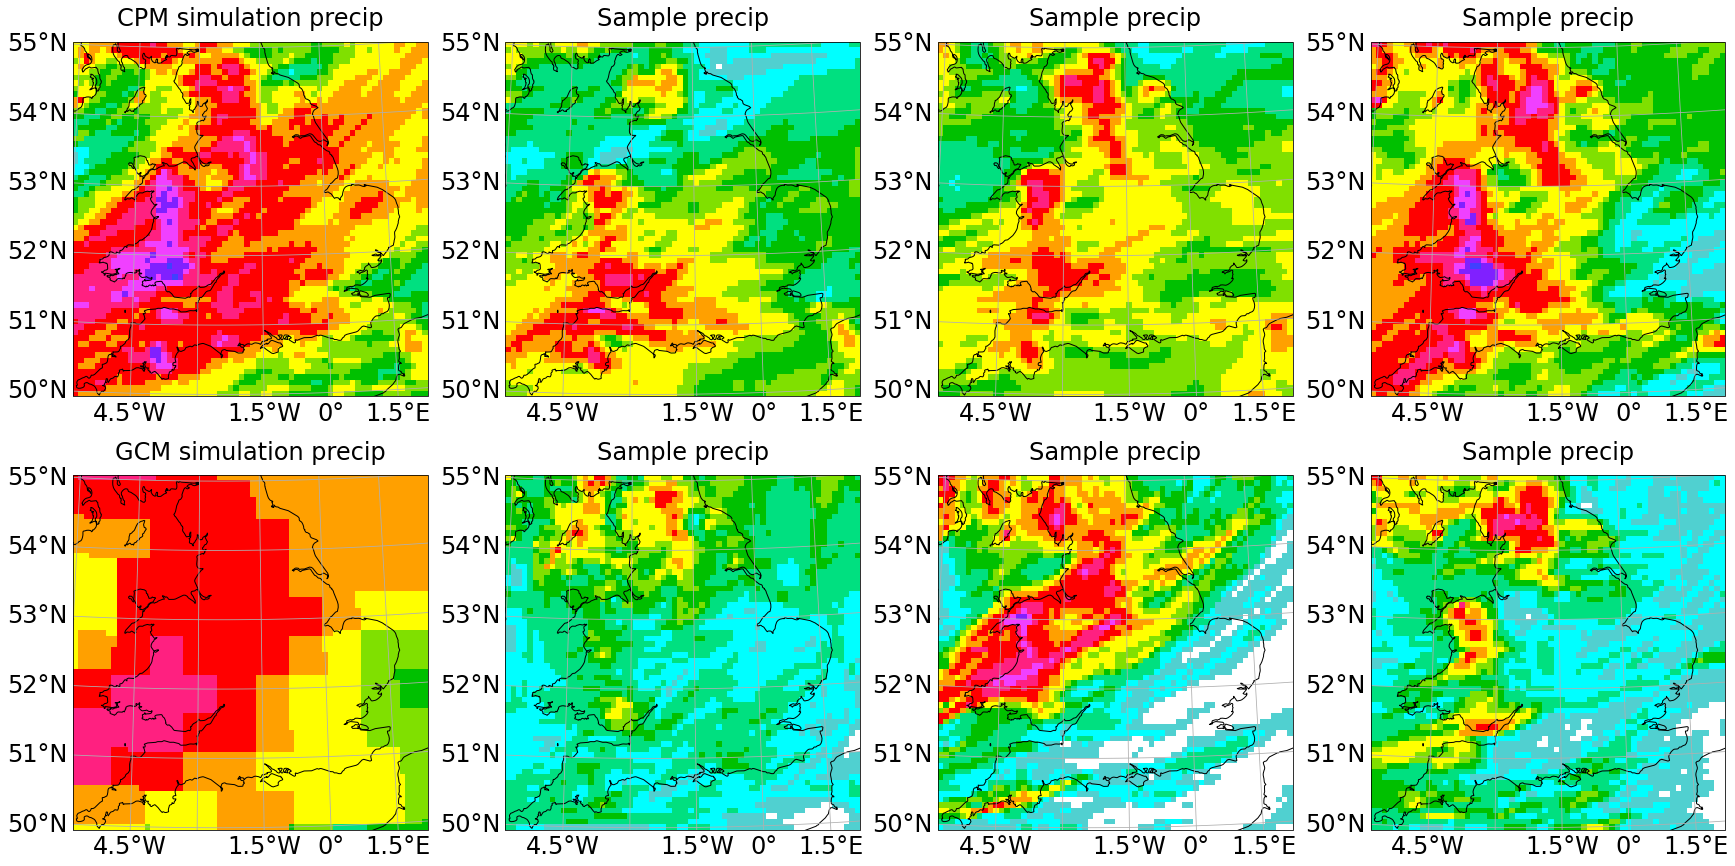

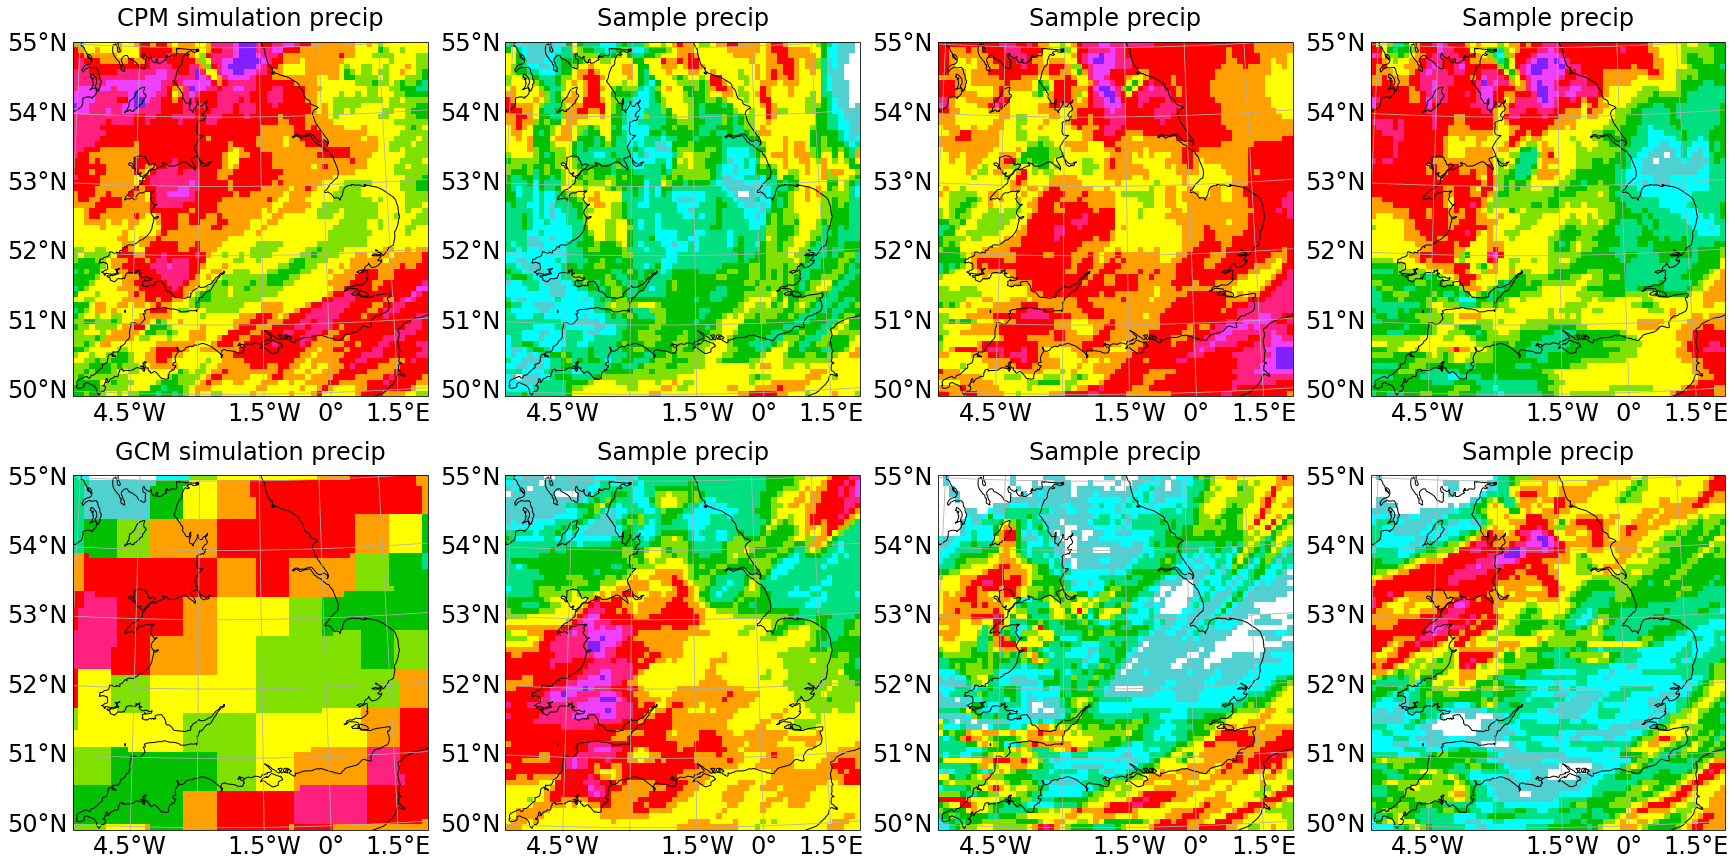

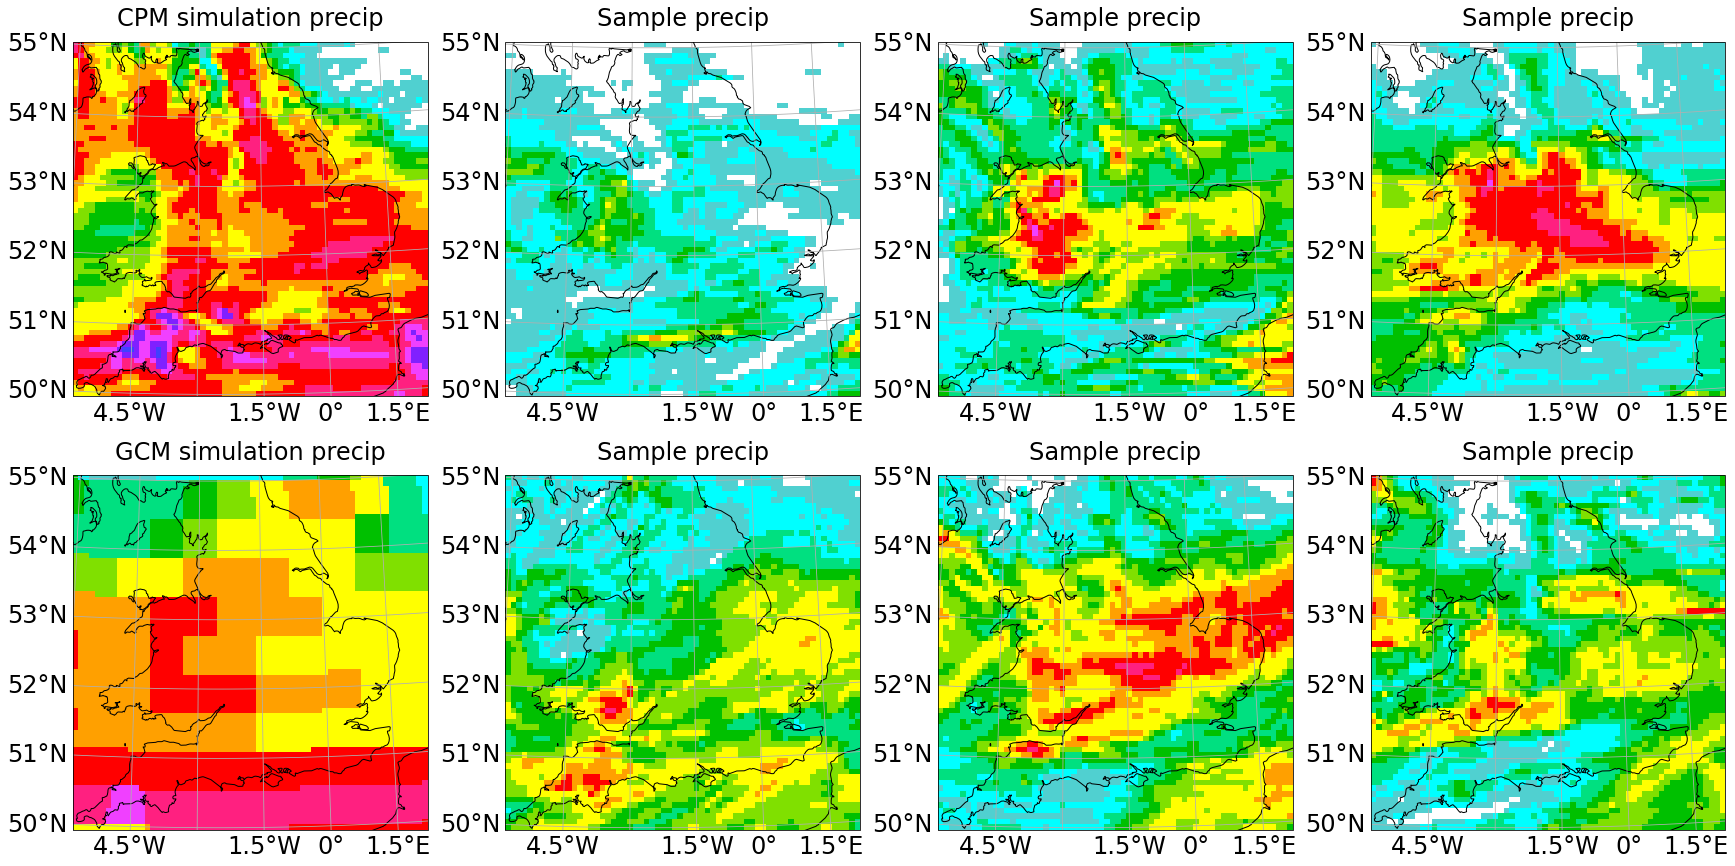

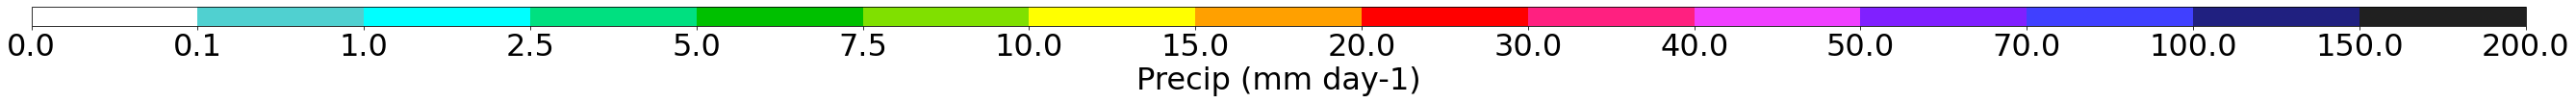

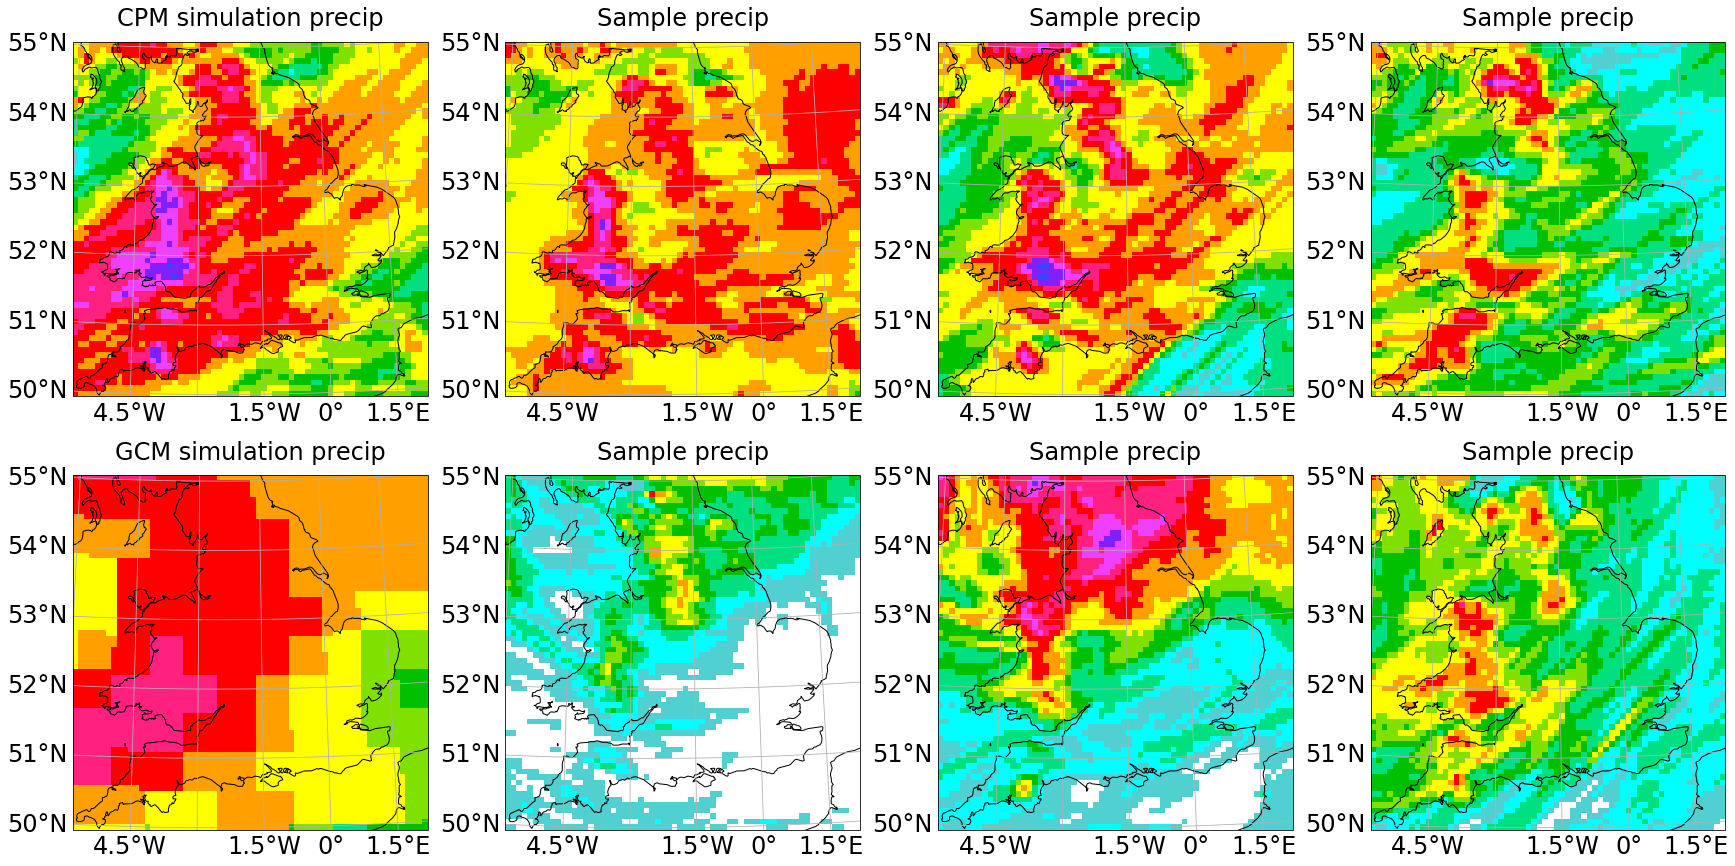

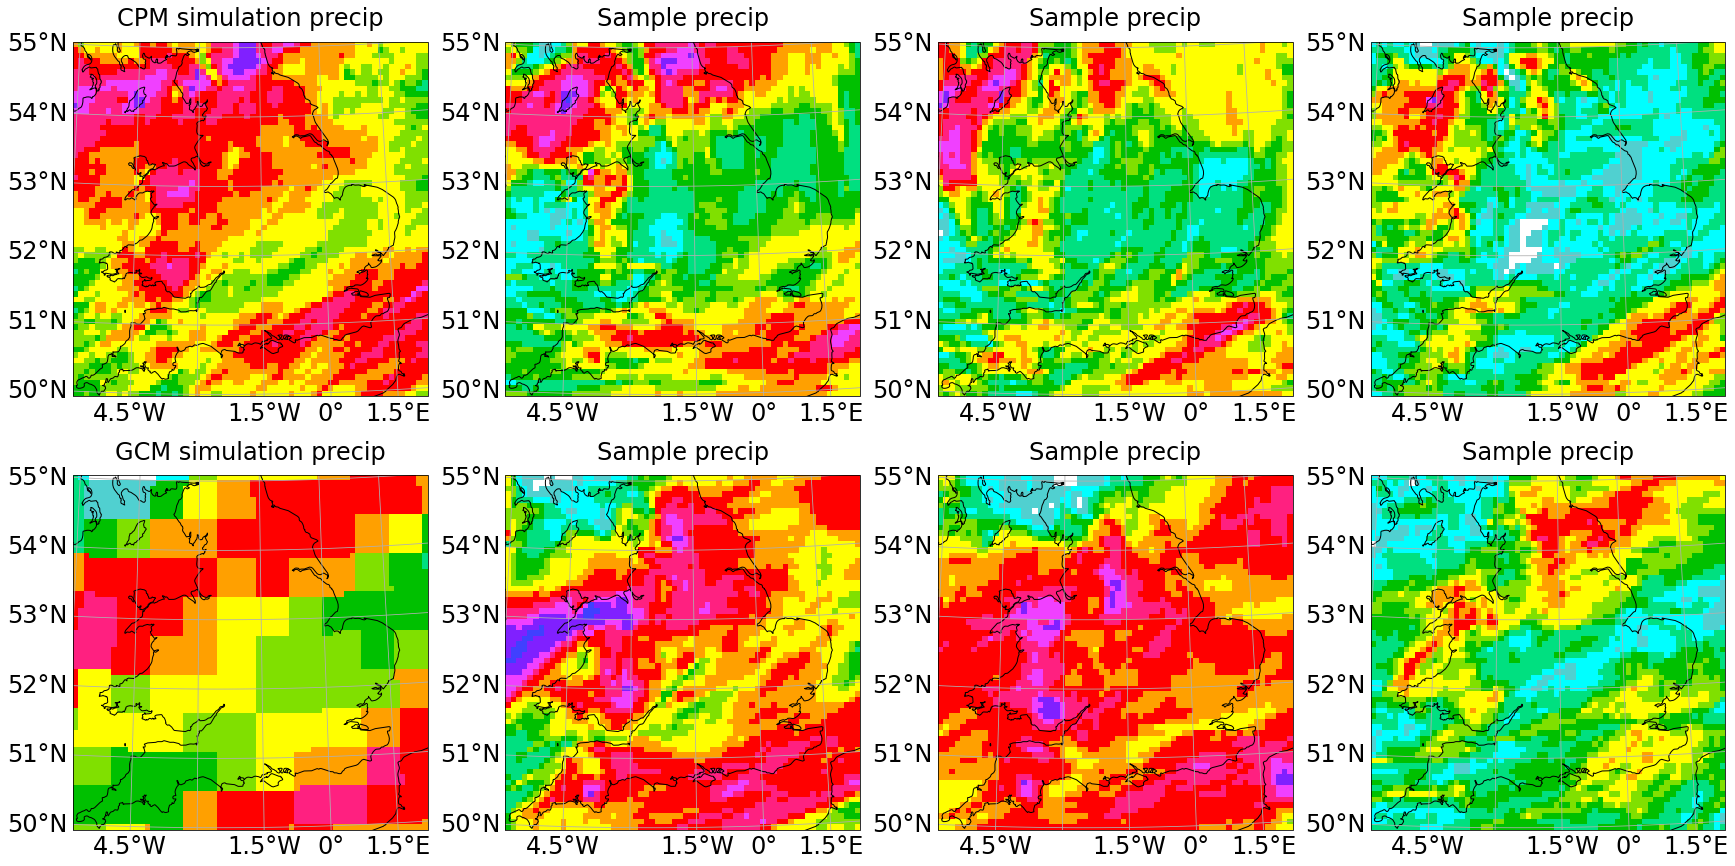

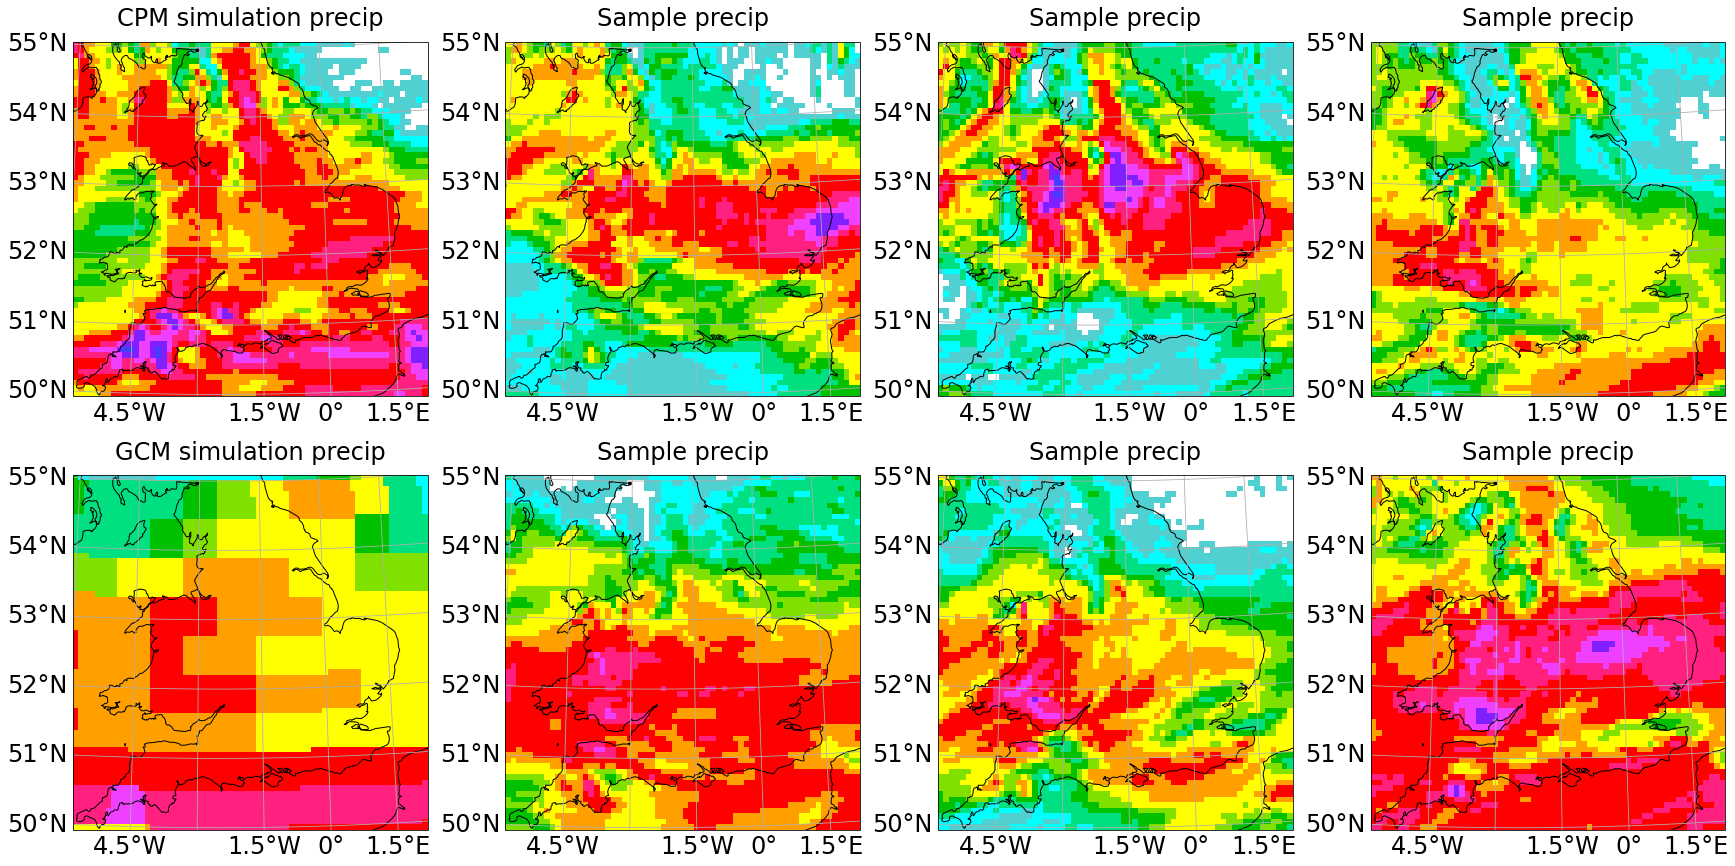

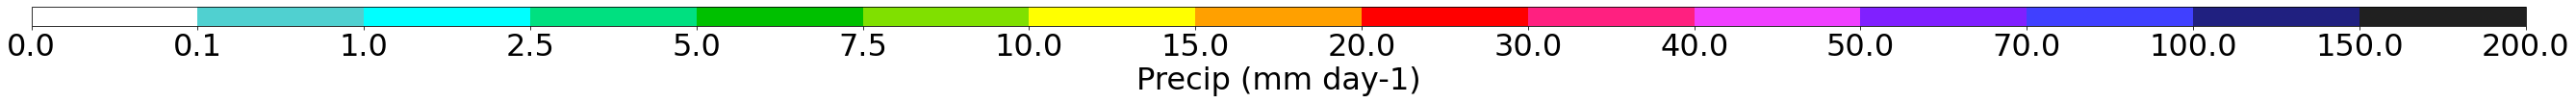

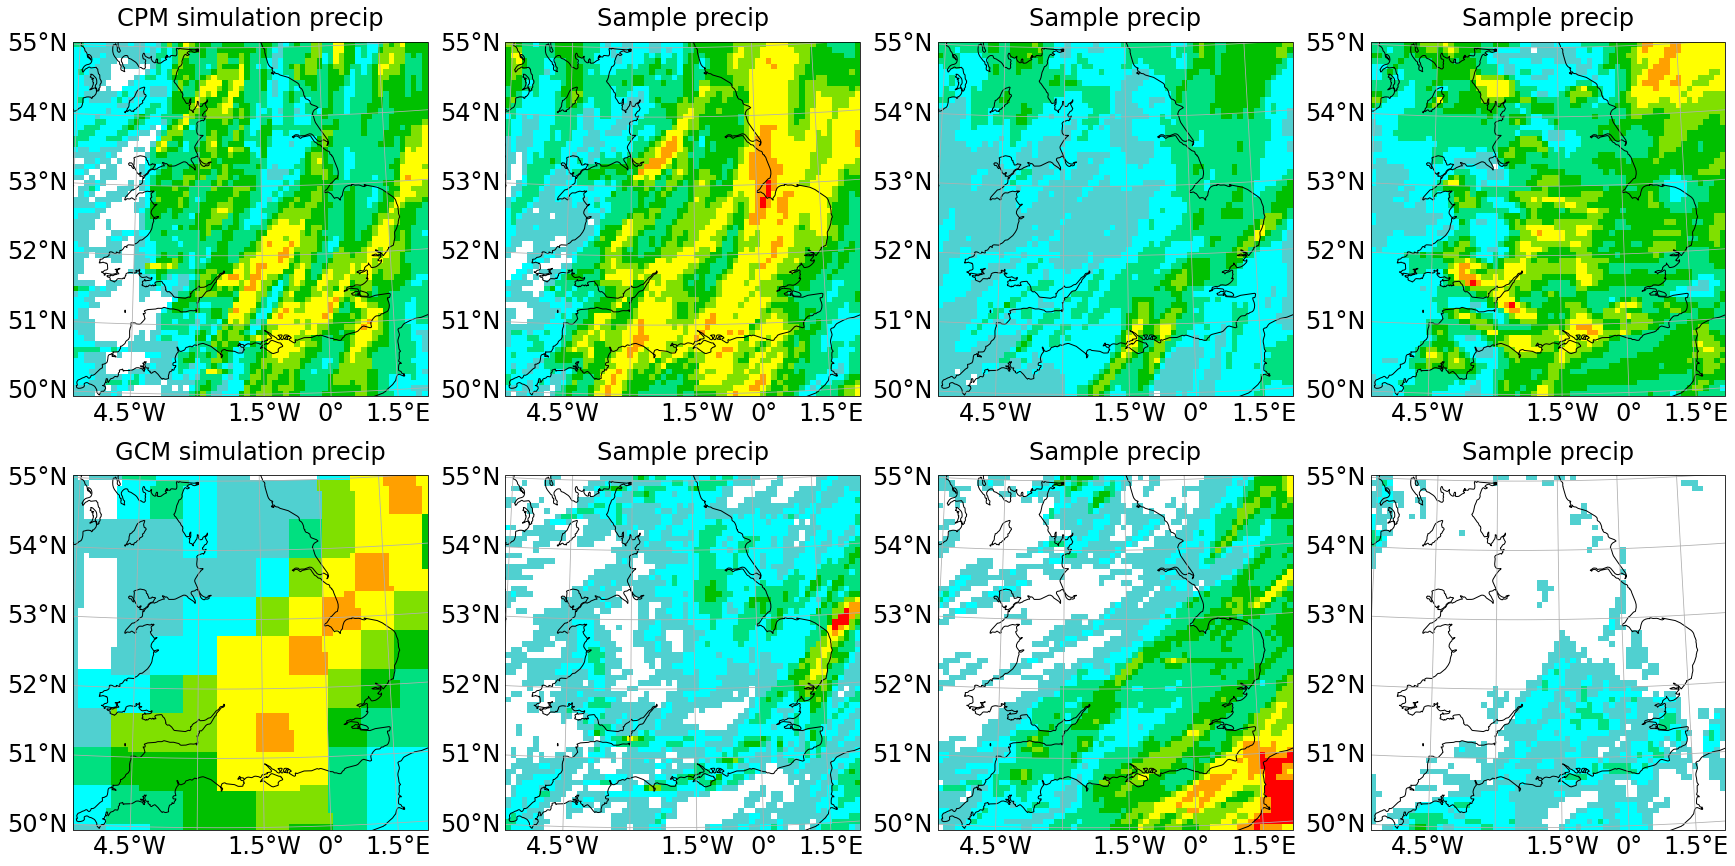

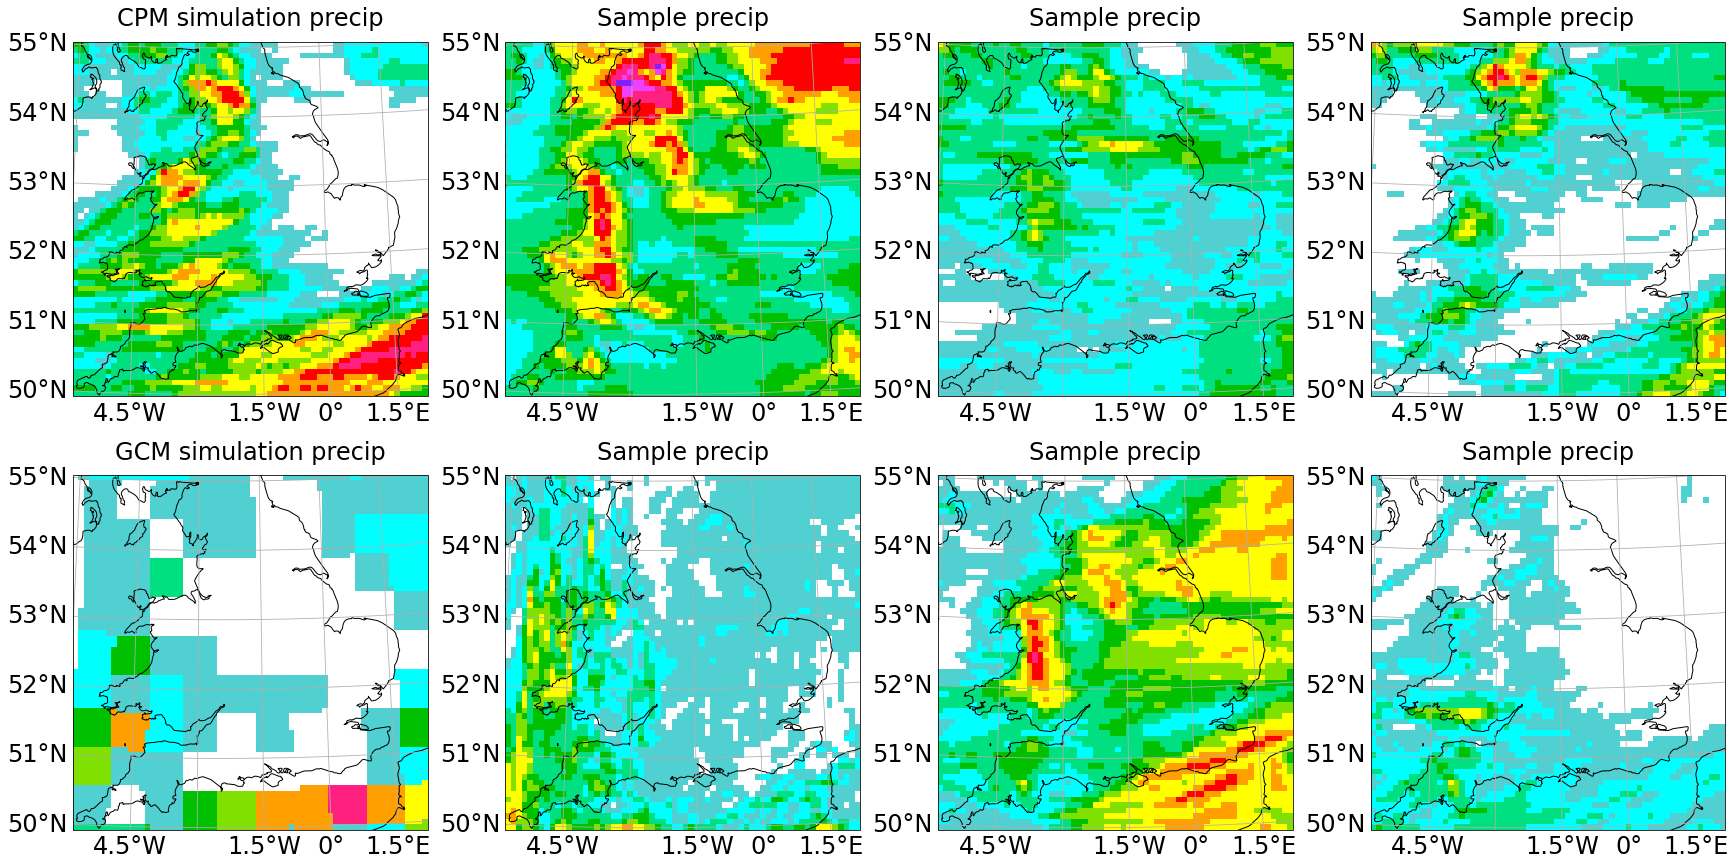

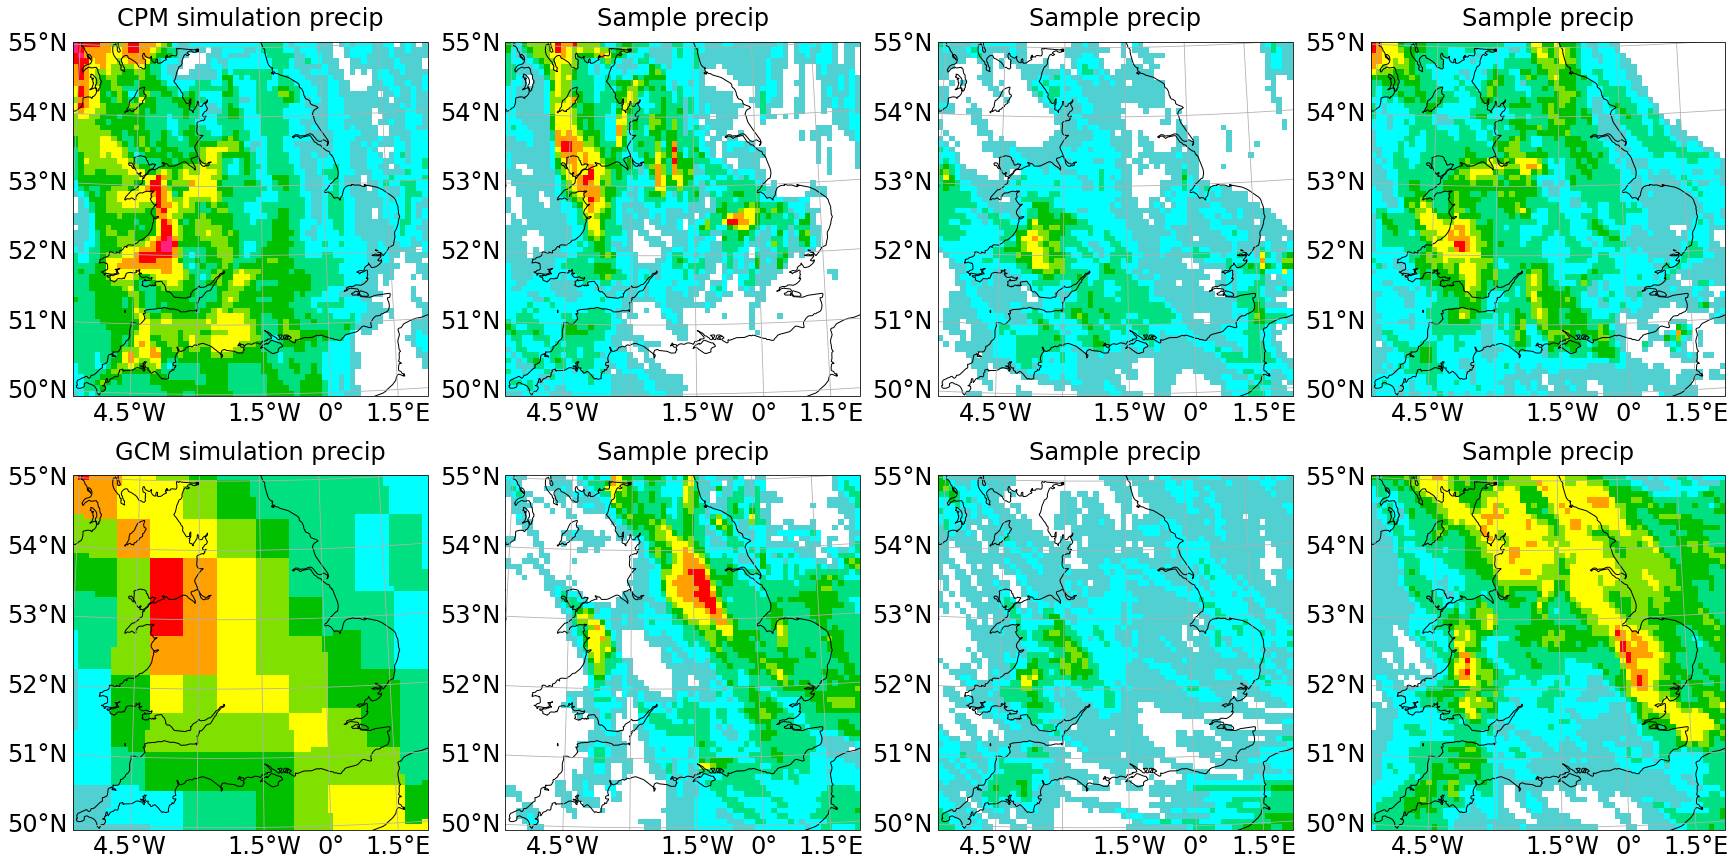

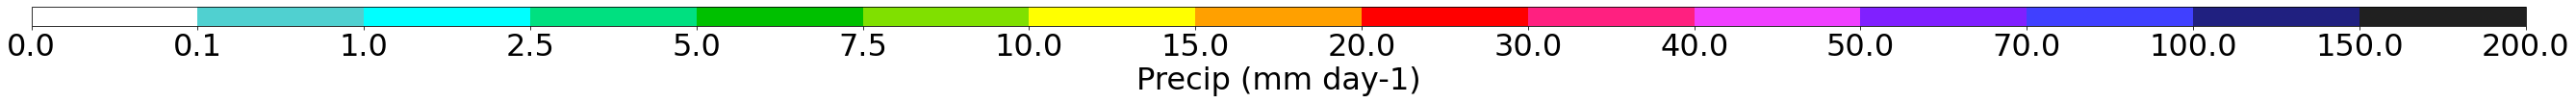

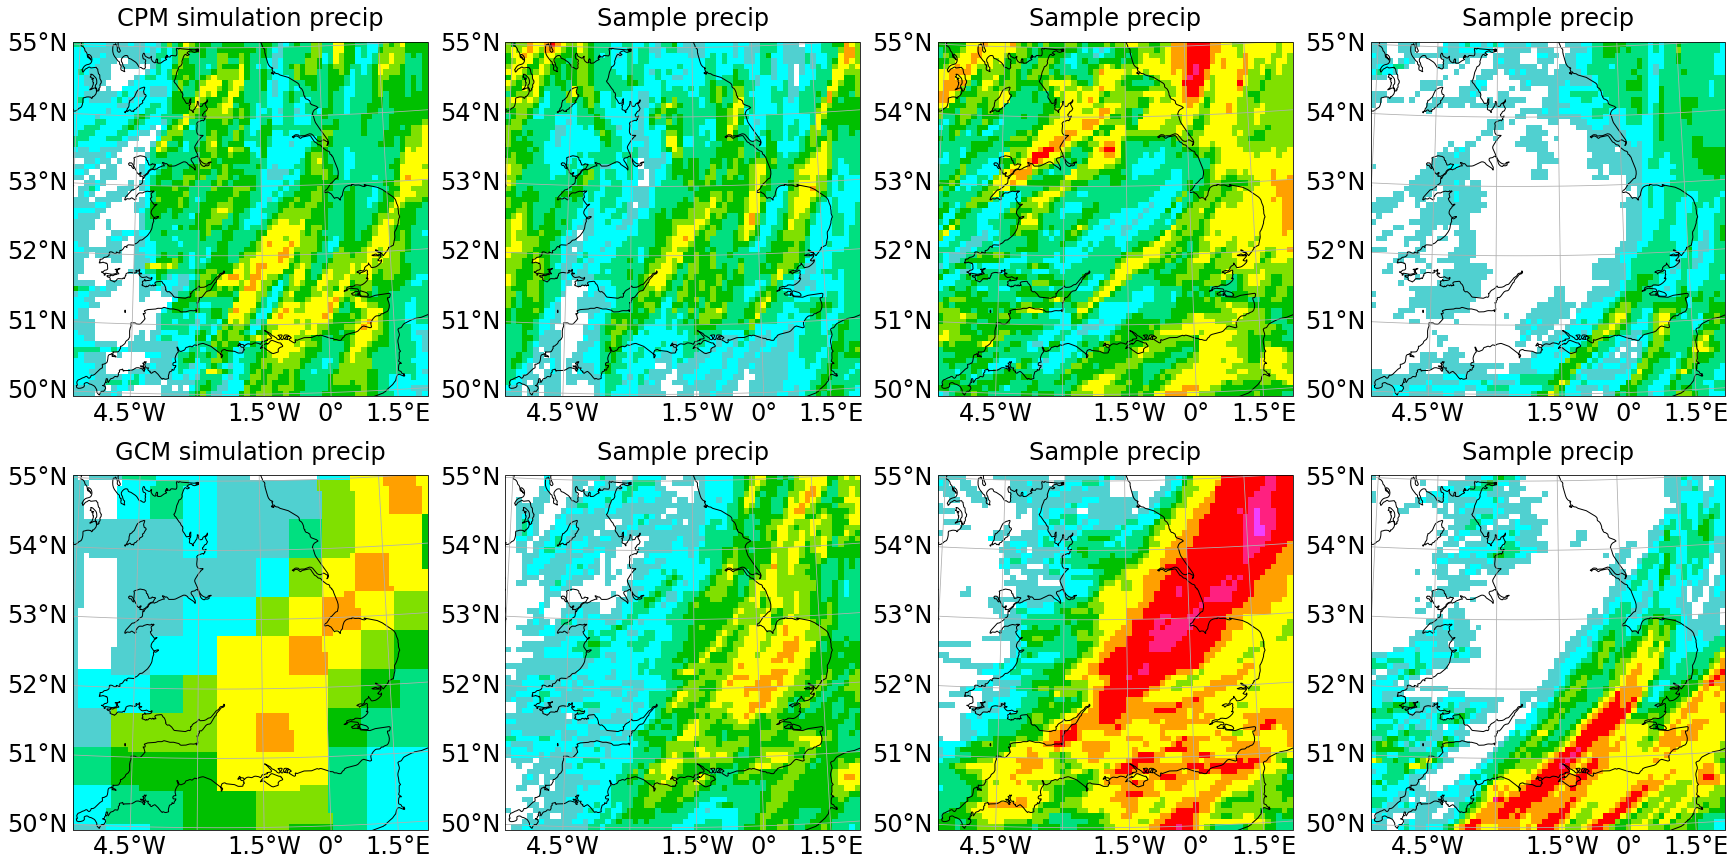

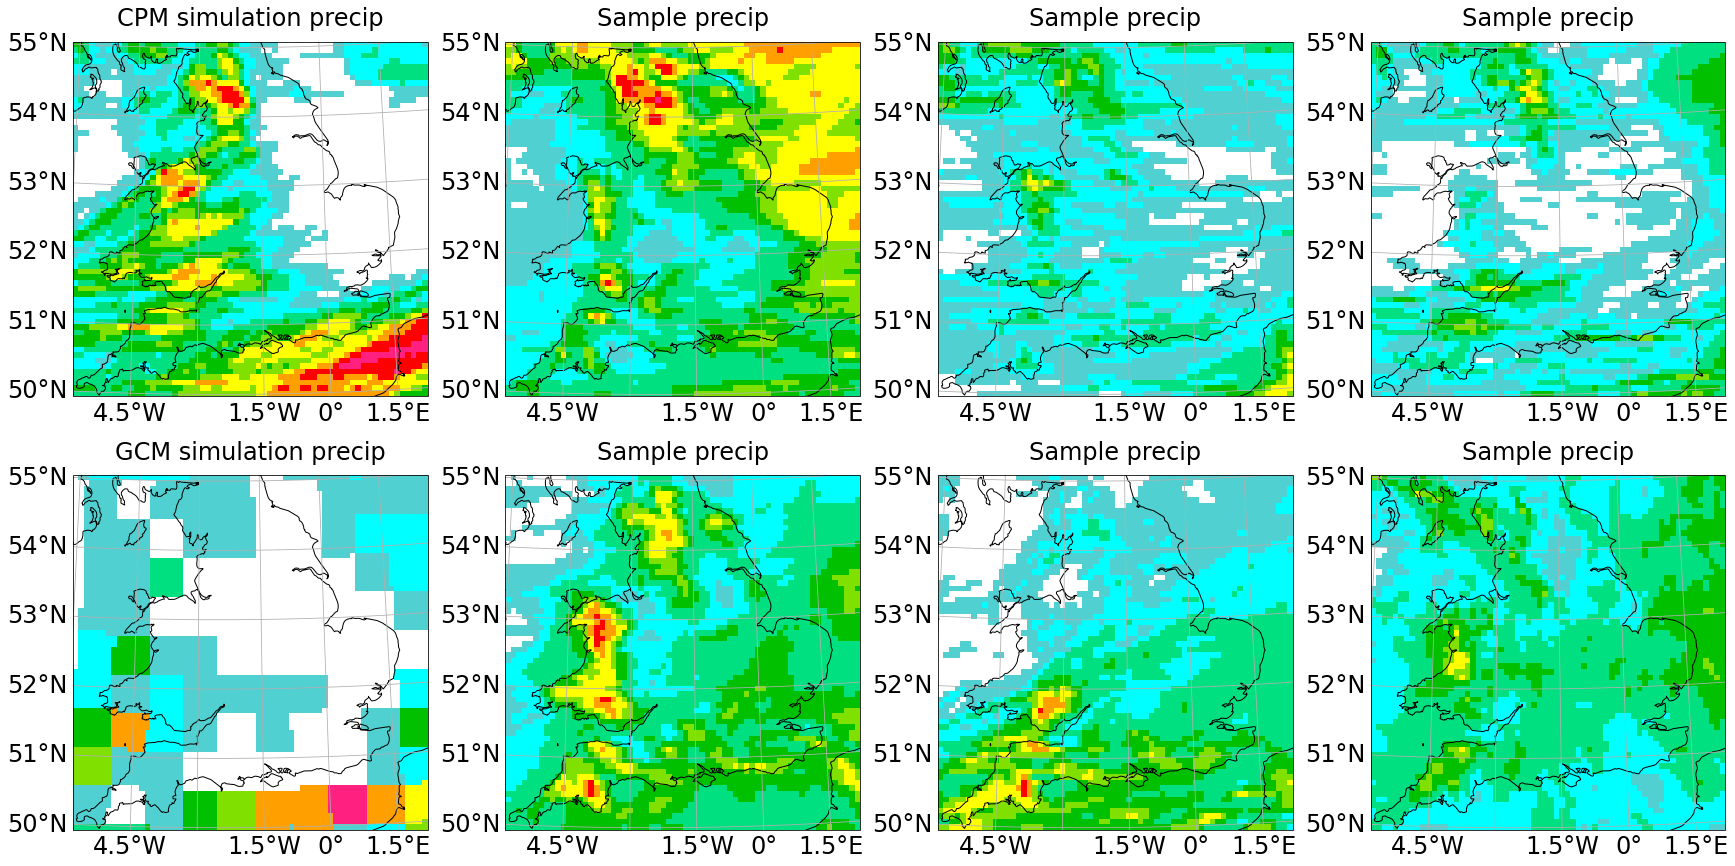

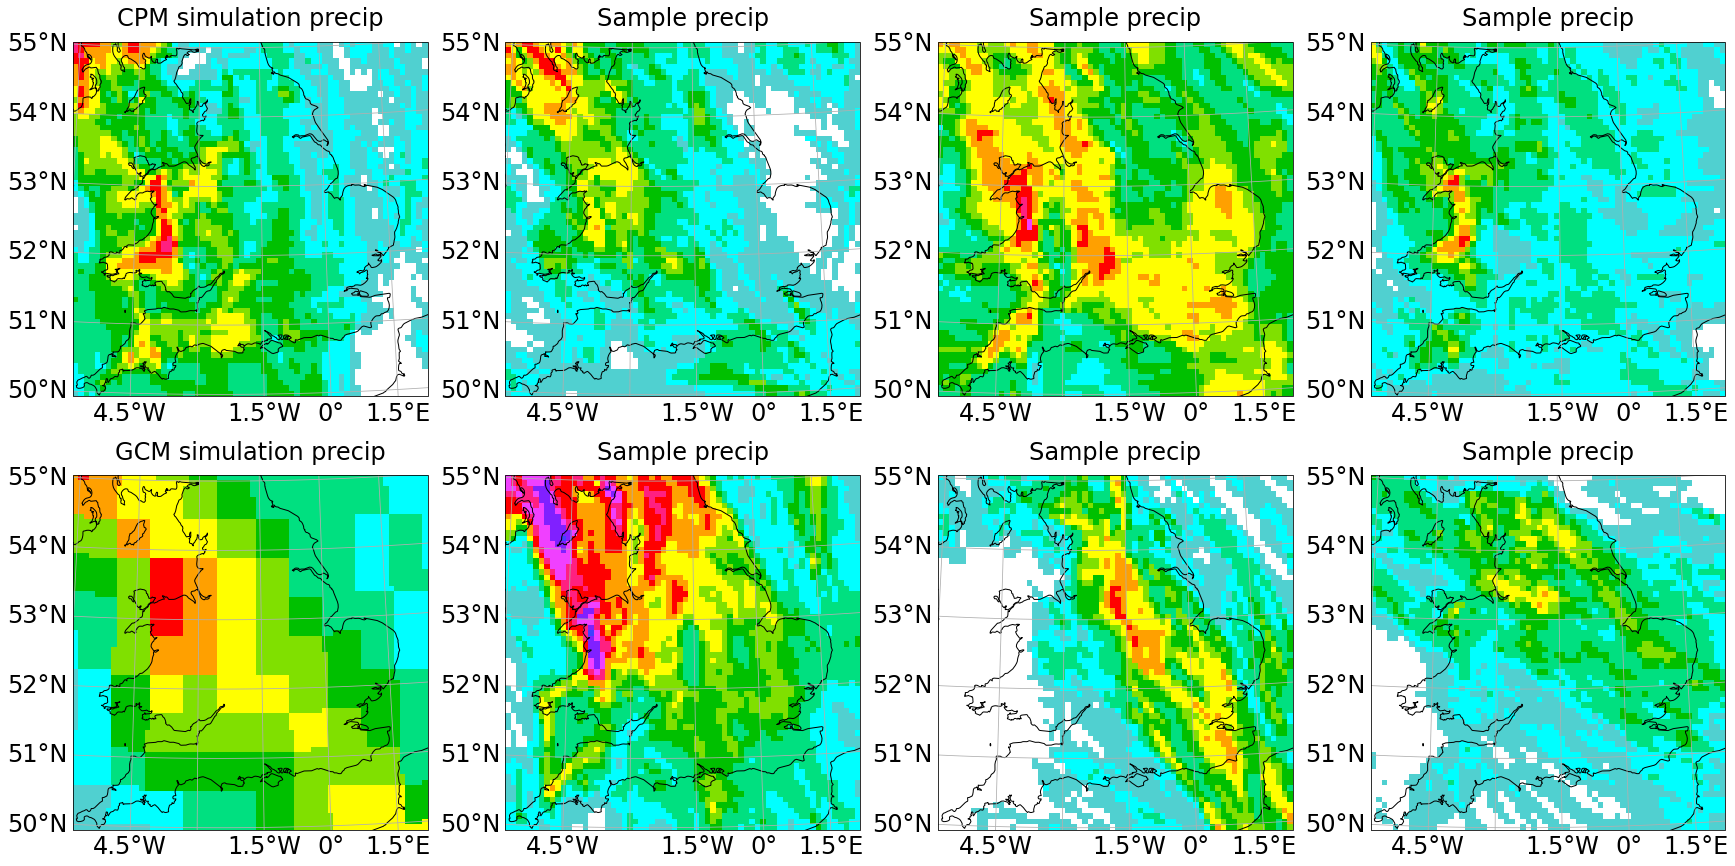

In [6]:
timestamp_chunks = [
    sorted_time[t:t+3] for t in [
        -20, 
        # math.ceil(len(sorted_time)*0.9),
        math.ceil(len(sorted_time)*0.81),
        # math.ceil(len(sorted_time)*0.5), 
        # 17
    ]
]
# timestamps = np.random.choice(sorted_time, size=2*3, replace=False)
vmin = 0.5#1e-1*3600*24
vmax = max(merged_ds['pred_pr'].max().values, merged_ds['target_pr'].max().values)


for timestamps in timestamp_chunks:
    for model in merged_ds["model"].values:
        ds = merged_ds.sel(model=model)
        show_samples(ds, timestamps, vmin, vmax)

## Frequency distribution

### Pixel

CPM

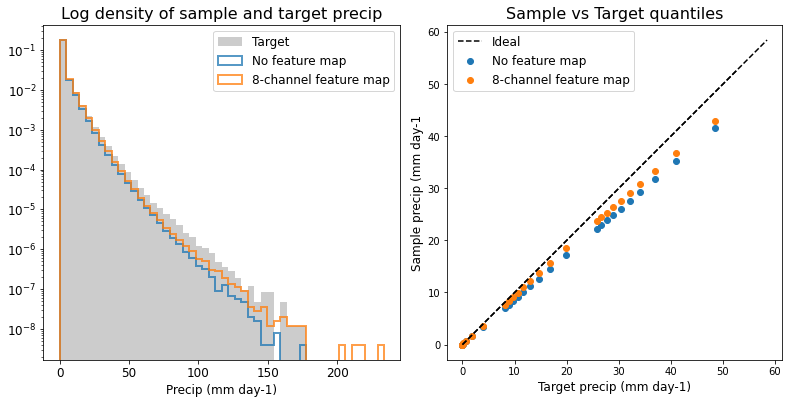

GCM

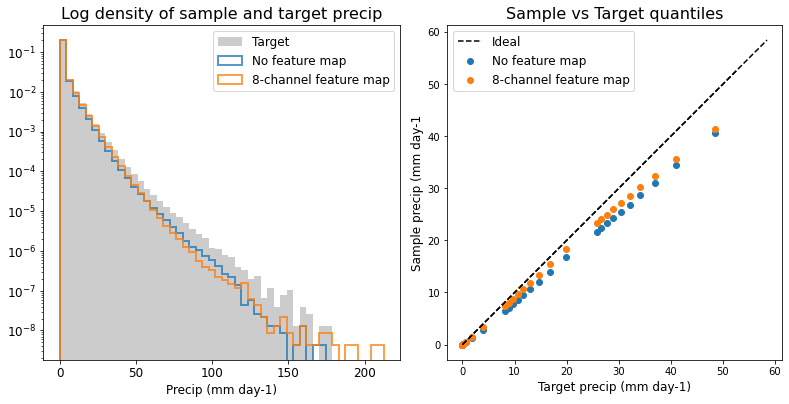

In [7]:
quantiles = np.concatenate([np.linspace(0.1,0.8,8), np.linspace(0.9,0.99,10), np.linspace(0.991,0.999,9)])

for source in pred_pr["source"].values:
    IPython.display.display_html(f"<h1>{source}</h1>", raw=True)
    distribution_figure(target_pr, pred_pr.sel(source=source), quantiles, "Distribution of pixel values")

### Mean over space

CPM

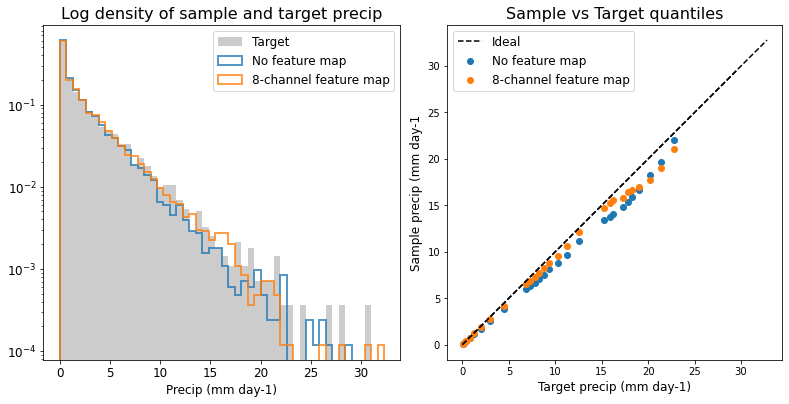

GCM

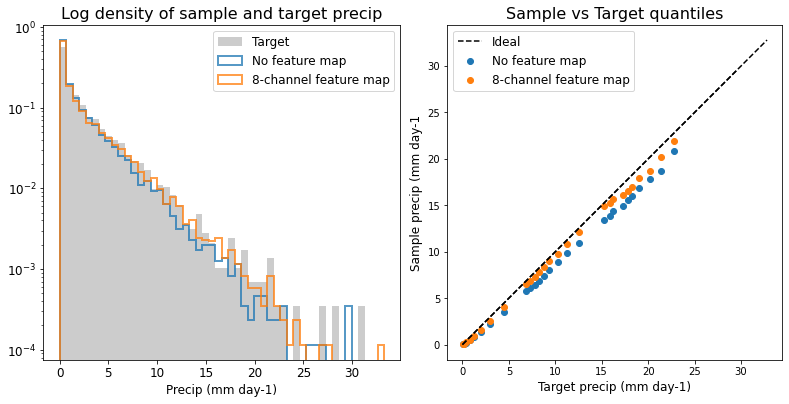

In [8]:
quantiles = np.concatenate([np.linspace(0.1,0.8,8), np.linspace(0.9,0.99,10), np.linspace(0.991,0.999,9)])

for source in total_pred_pr["source"].values:
    IPython.display.display_html(f"<h1>{source}</h1>", raw=True)
    distribution_figure(total_target_pr, total_pred_pr.sel(source=source), quantiles, "Distribution of mean precip over space")

## Bias

CPM

gcmx-4x_bham_vorticity850_random-fixed-gcmx-vort-grid

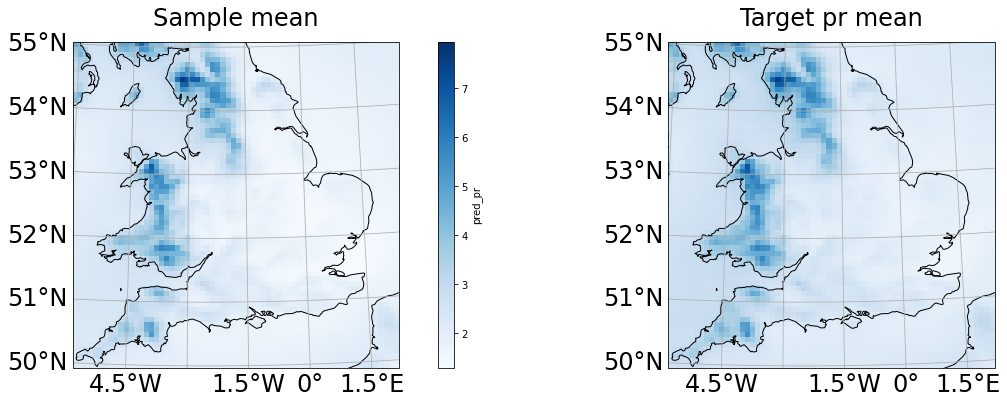

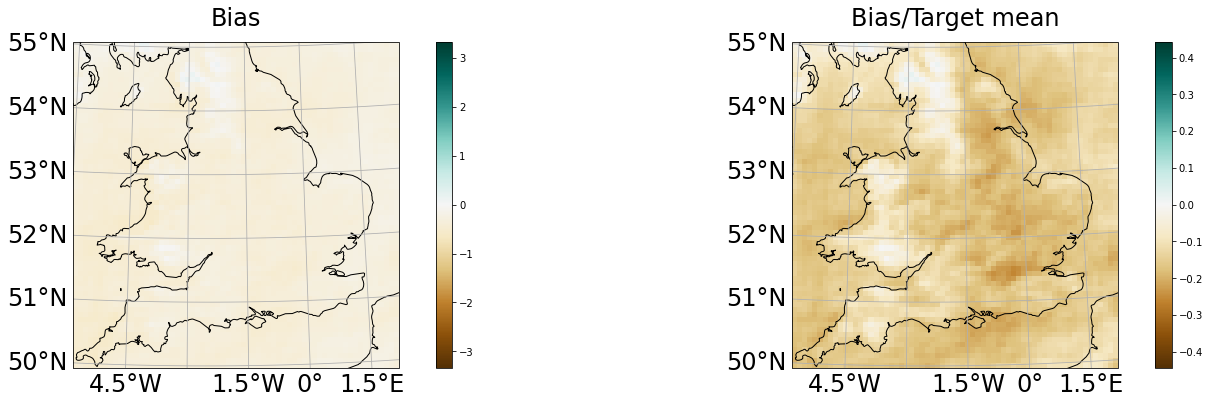

gcmx-4x_bham_vorticity850_random-learnt-map-8

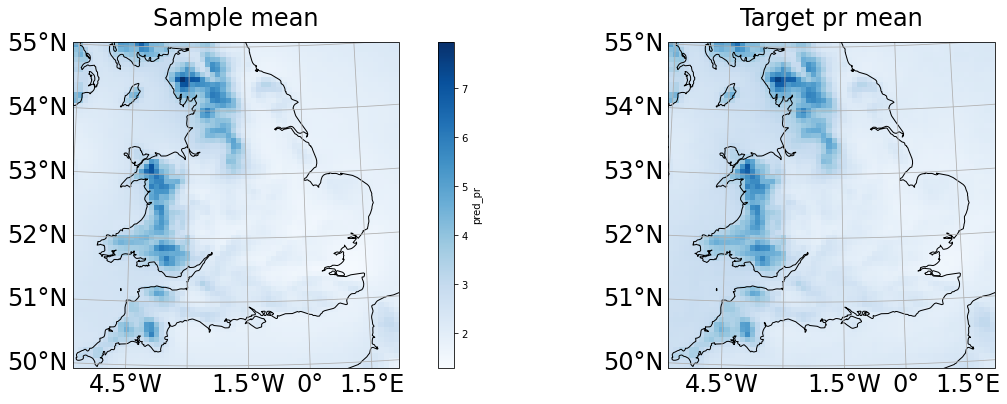

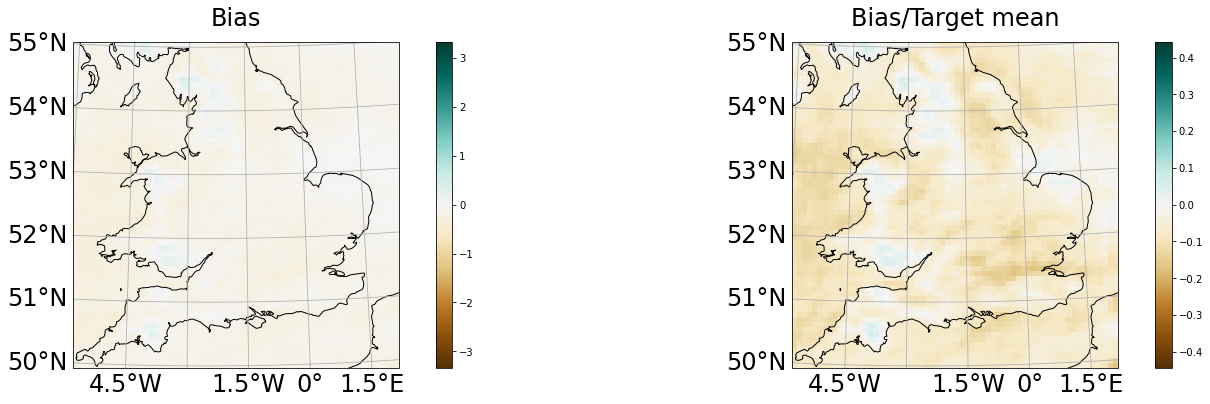

GCM

gcmx-4x_bham_vorticity850_random-fixed-gcmx-vort-grid

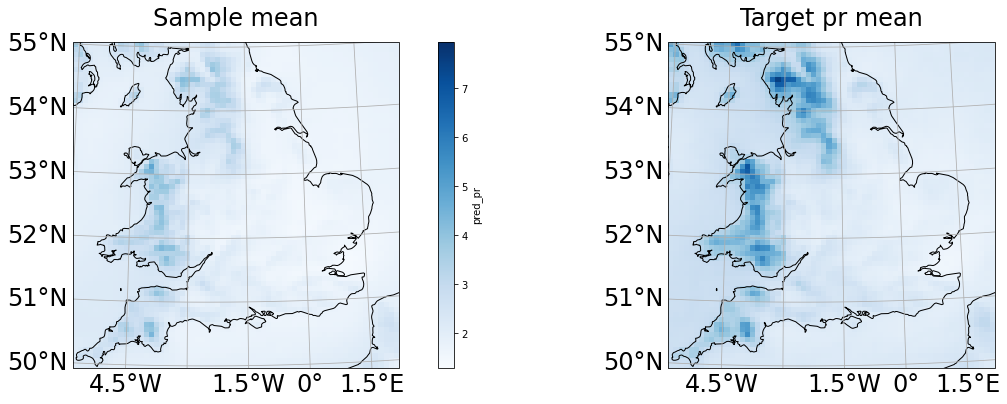

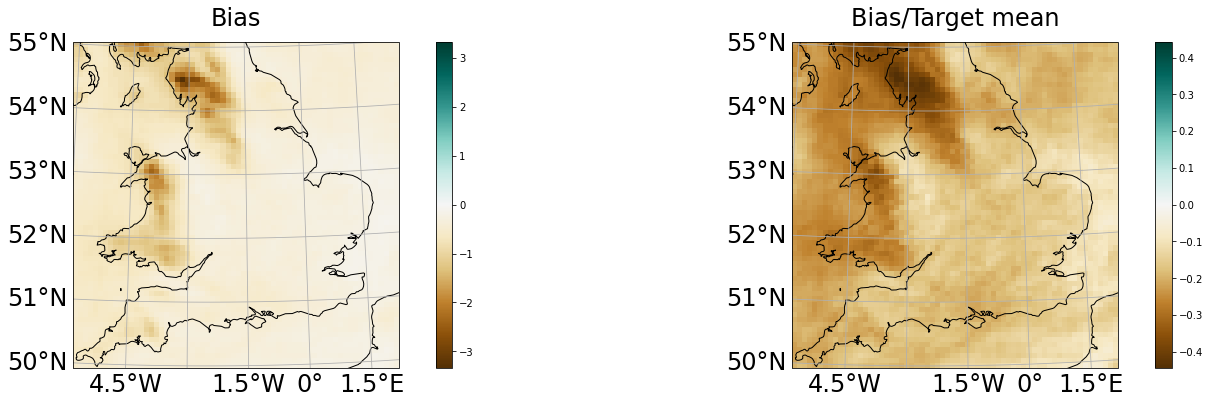

gcmx-4x_bham_vorticity850_random-learnt-map-8

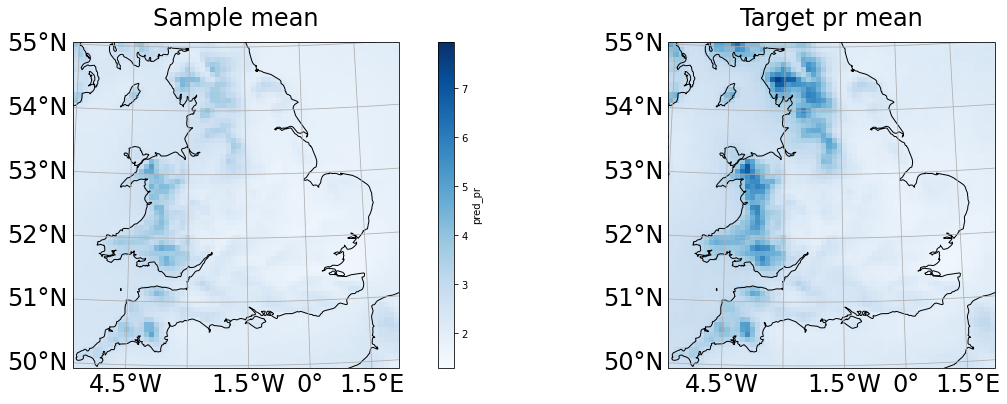

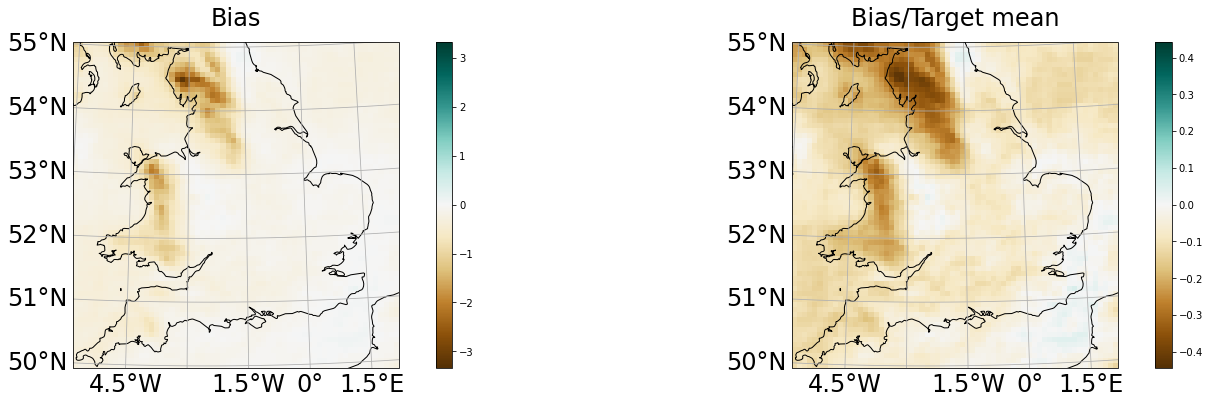

In [9]:
plot_mean_bias(merged_ds)

## Standard deviation

CPM

gcmx-4x_bham_vorticity850_random-fixed-gcmx-vort-grid

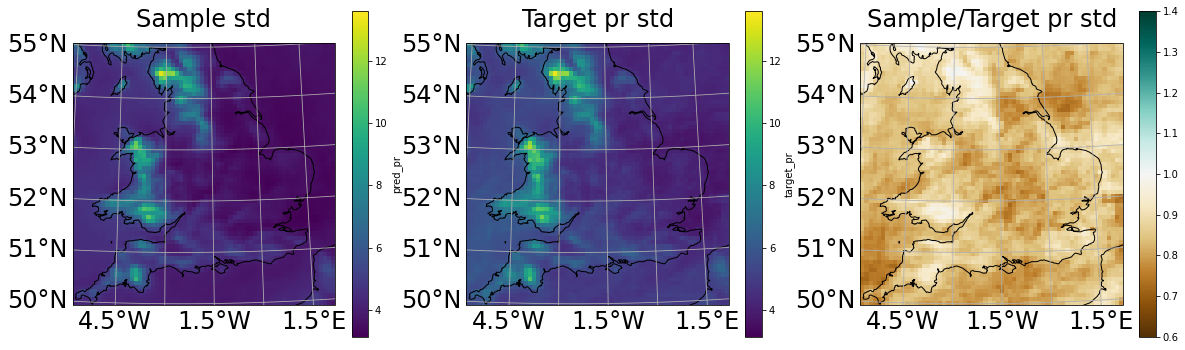

gcmx-4x_bham_vorticity850_random-learnt-map-8

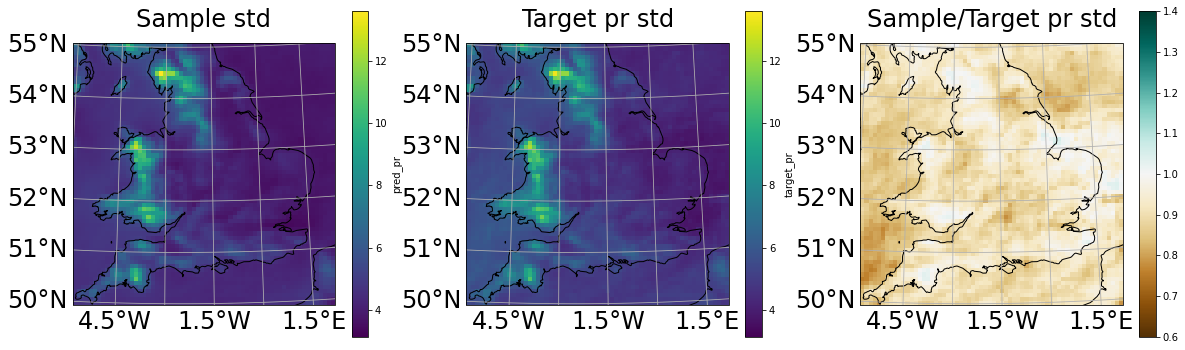

GCM

gcmx-4x_bham_vorticity850_random-fixed-gcmx-vort-grid

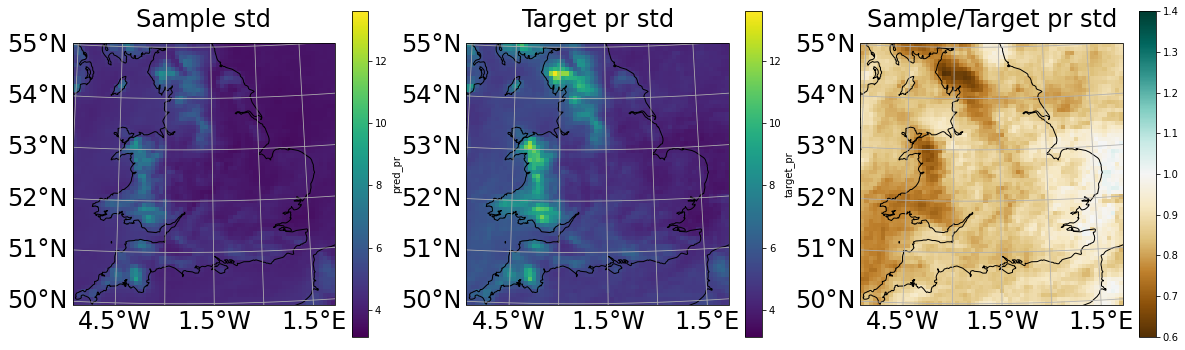

gcmx-4x_bham_vorticity850_random-learnt-map-8

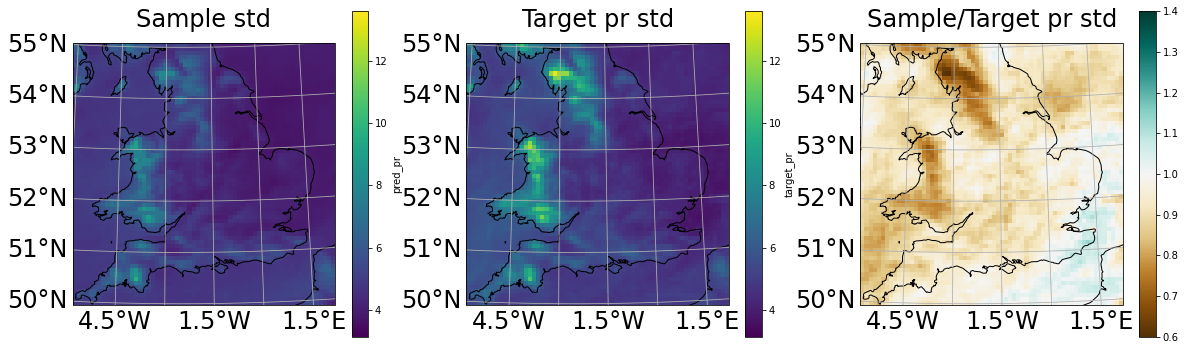

In [10]:
plot_std(merged_ds)

## Scatter

In [11]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())


# ax = axs

# ax.scatter(x=merged_ds["pred_pr"], y=merged_ds["target_pr"].values[None, :].repeat(len(merged_ds["sample_id"]), 0), alpha=0.05)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')


In [12]:
# sample_ids = np.arange(9).reshape(3, 3)

# fig, axs = plt.subplots(sample_ids.shape[0], sample_ids.shape[1], figsize=(30, 12))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())

# for i, sample_id in enumerate(sample_ids.flatten()):
#     ax = axs[i//3][i%3]

#     ax.scatter(x=merged_ds["pred_pr"].sel(sample_id=sample_id), y=merged_ds["target_pr"], alpha=0.1)
#     ax.plot([0, tr], [0, tr], linewidth=1, color='green')
#     ax.set_xlabel(f"Sample {sample_id} pr")
#     ax.set_ylabel(f"Target pr")
    
# plt.show()

In [13]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(total_pred_pr.max(), total_target_pr.max())

# ax = axs

# ax.scatter(x=total_pred_pr, y=total_target_pr.values[None, :].repeat(len(total_pred_pr["sample_id"]), 0), alpha=0.25)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')

# plt.show()

## PSD

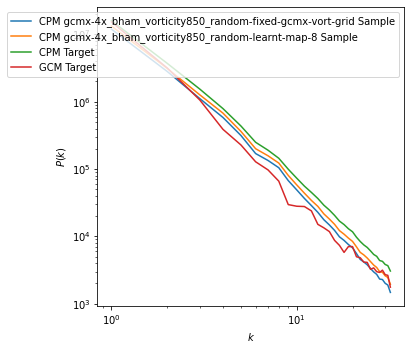

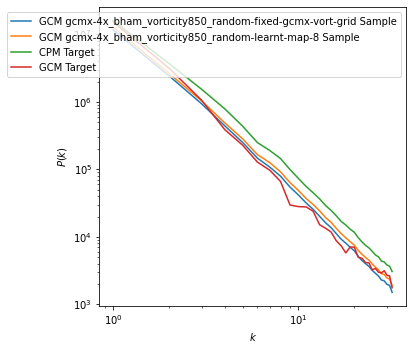

In [14]:
simulation_data = {"CPM Target": merged_ds.sel(source="CPM")["target_pr"], "GCM Target": merged_ds.sel(source="GCM")["target_pr"]}
ml_data = { f"{source} {model} Sample": merged_ds.sel(source=source, model=model)["pred_pr"] for model in merged_ds["model"].values for source in ["CPM"] }
plot_psd(ml_data | simulation_data)

simulation_data = {"CPM Target": merged_ds.sel(source="CPM")["target_pr"], "GCM Target": merged_ds.sel(source="GCM")["target_pr"]}
ml_data = { f"{source} {model} Sample": merged_ds.sel(source=source, model=model)["pred_pr"] for model in merged_ds["model"].values for source in ["GCM"] }
plot_psd(ml_data | simulation_data)

## Correlation